# Deterministic Optimal Economic Growth Model

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demdoc02.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2021-Oct-01</i>
<hr>

## About

Social benefit maximizing social planner must decide how much society should consume and invest.

* State
  - k     capital stock
* Control
  - q     consumption rate
* Parameters
  - 𝛼     capital share
  - 𝛿     capital depreciation rate
  - 𝜃     relative risk aversion
  - 𝜌     continuous discount rate


## Preliminary tasks

### Import relevant packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from compecon import BasisChebyshev, OCmodel

### Model parameters

In [2]:
𝛼 =  0.4        # capital share
𝛿 =  0.1        # capital depreciation rate
𝜃 =  2.0        # relative risk aversion
𝜌 =  0.05       # continuous discount rate

### Approximation structure

In [3]:
n = 21          # number of basis functions
kmin = 1        # minimum state
kmax = 7        # maximum state
basis = BasisChebyshev(n, kmin, kmax, labels=['Capital Stock'])  # basis functions

### Steady-state

In [4]:
kstar = ((𝛿+𝜌)/𝛼)**(1/(𝛼-1))       # capital stock
qstar = kstar**𝛼 - 𝛿*kstar         # consumption rate
vstar = ((1/(1-𝜃))*qstar**(1-𝜃))/𝜌 # value
lstar =  qstar ** (-𝜃)             # shadow price

steadystate = pd.Series([kstar, qstar, vstar, lstar],
                       index=['Capital stock', 'Rate of consumption', 'Value Function', 'Shadow Price'])

steadystate

Capital stock           5.127998
Rate of consumption     1.410200
Value Function        -14.182390
Shadow Price            0.502850
dtype: float64

## Solve HJB equation by collocation

### Initial guess

In [5]:
k = basis.nodes
basis.y = ((𝜌*k)**(1-𝜃))/(1-𝜃)

### Define model and solve it.

In [6]:
def control(k, Vk, 𝛼,𝛿,𝜃,𝜌):
    return Vk**(-1/𝜃)

def reward(k, q, 𝛼,𝛿,𝜃,𝜌):
    return (1/(1-𝜃)) * q**(1-𝜃)

def transition(k, q, 𝛼,𝛿,𝜃,𝜌):
    return k**𝛼 - 𝛿*k - q

model = OCmodel(basis, control, reward, transition, rho=𝜌, params=[𝛼,𝛿,𝜃,𝜌])
data = model.solve()

Solving optimal control model
iter change       time    
------------------------------
   0       8.4e+00    0.0020
   1       7.8e-01    0.0030
   2       1.5e-01    0.0030
   3       8.1e-03    0.0040
   4       2.9e-05    0.0050
   5       4.4e-10    0.0050
Elapsed Time =    0.00 Seconds


## Plots

### Optimal policy

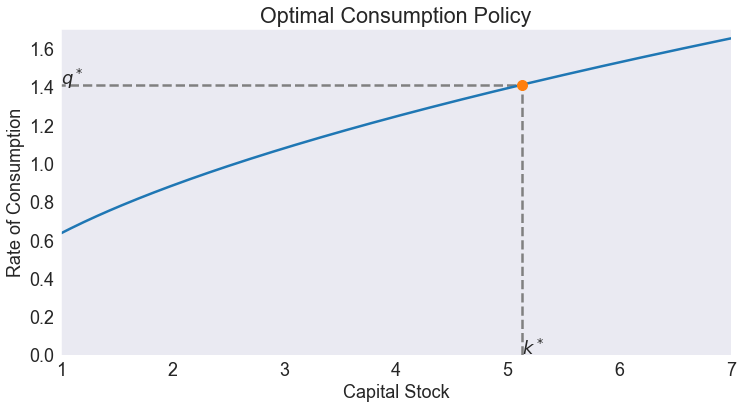

In [7]:
fig, ax = plt.subplots()
data['control'].plot(ax=ax)
ax.set(title='Optimal Consumption Policy',
       xlabel='Capital Stock',
       ylabel='Rate of Consumption',
       xlim=[kmin, kmax])
ax.set_ylim(bottom=0)
ax.hlines(qstar, 0, kstar, colors=['gray'], linestyles=['--'])
ax.vlines(kstar, 0, qstar, colors=['gray'], linestyles=['--'])
ax.annotate('$q^*$', (kmin, qstar))
ax.annotate('$k^*$', (kstar, 0))
ax.plot(kstar, qstar, '.', ms=20);

### Value function

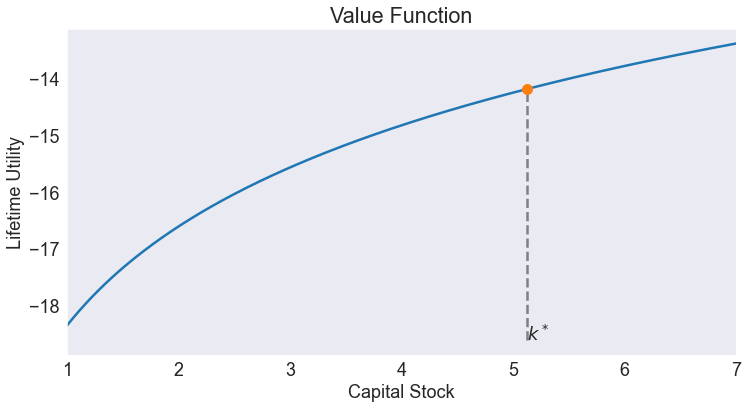

In [8]:
fig, ax = plt.subplots()
data['value'].plot(ax=ax)
ax.set(title='Value Function',
       xlabel='Capital Stock',
       ylabel='Lifetime Utility',
       xlim=[kmin, kmax])

lb = ax.get_ylim()[0]
ax.vlines(kstar, lb , vstar, colors=['gray'], linestyles=['--'])
ax.annotate('$k^*$', (kstar, lb))
ax.plot(kstar, vstar, '.', ms=20);

### Shadow price

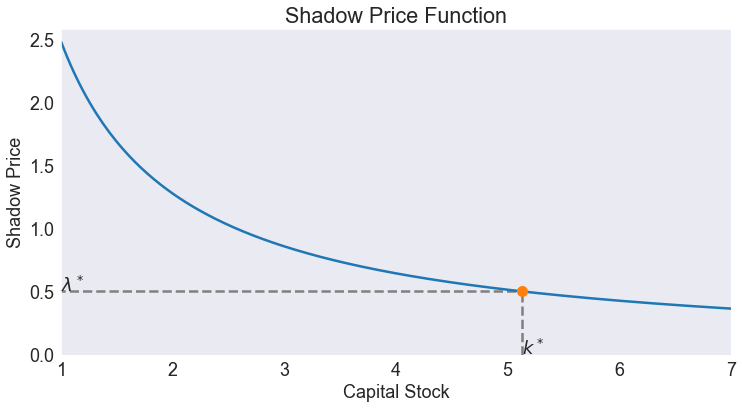

In [9]:
data['shadow'] = model.Value(data.index, 1)

fig, ax = plt.subplots()
data['shadow'].plot(ax=ax)
ax.set(title='Shadow Price Function',
       xlabel='Capital Stock',
       ylabel='Shadow Price',
       xlim=[kmin, kmax])

ax.set_ylim(bottom=0)
ax.hlines(lstar, 0, kstar, colors=['gray'], linestyles=['--'])
ax.vlines(kstar, 0 , lstar, colors=['gray'], linestyles=['--'])
ax.annotate('$\lambda^*$', (kmin, lstar))
ax.annotate('$k^*$', (kstar, 0))
ax.plot(kstar, lstar, '.', ms=20);

### Residual

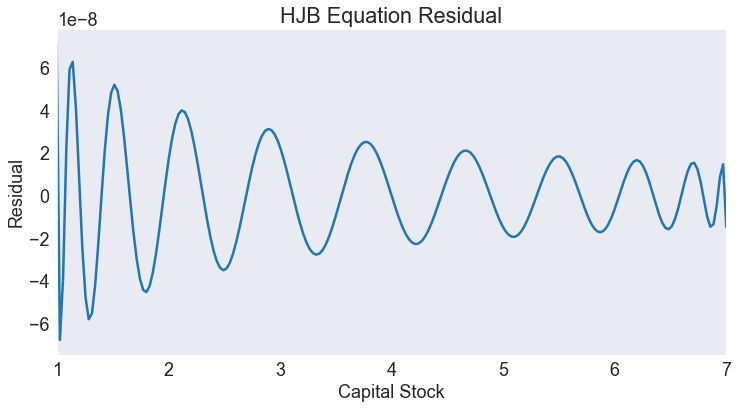

In [10]:
fig, ax = plt.subplots()
data['resid'].plot(ax=ax)
ax.set(title='HJB Equation Residual',
       xlabel='Capital Stock',
       ylabel='Residual',
       xlim=[kmin, kmax]);

## Simulate the model

### Initial state and time horizon

In [11]:
k0 = kmin  # initial capital stock
T  = 50    # time horizon

### Simulation and plot

PARAMETER xnames NO LONGER VALID. SET labels= AT OBJECT CREATION


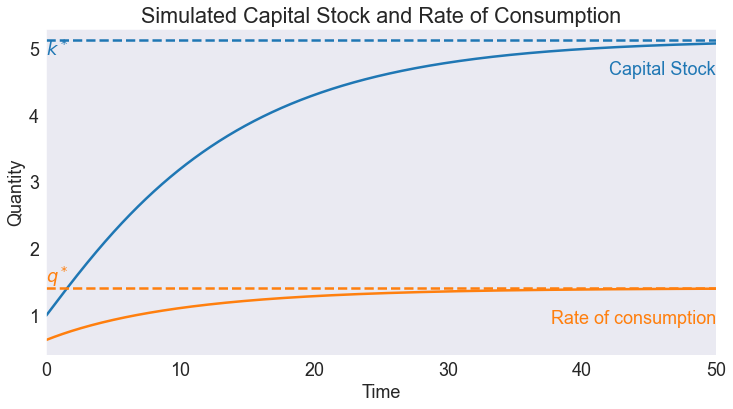

In [12]:
fig, ax = plt.subplots()
model.simulate([k0], T).plot(ax=ax)
ax.set(title='Simulated Capital Stock and Rate of Consumption',
       xlabel='Time',
       ylabel='Quantity',
       xlim=[0, T])

ax.axhline(kstar, ls='--', c='C0')
ax.axhline(qstar, ls='--', c='C1')

ax.annotate('$k^*$', (0, kstar), color='C0', va='top')
ax.annotate('$q^*$', (0, qstar), color='C1', va='bottom')

ax.annotate('\nCapital Stock', (T, kstar), color='C0', ha='right', va='top')
ax.annotate('\nRate of consumption', (T, qstar), color='C1', ha='right', va='top')

ax.legend([]);